In [1]:
import pandas as pd
from rich.jupyter import display
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
# import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="LogisticRegression")


In [2]:
df = pd.read_csv('../../data/player_game_statistics.csv')
display(df.head())

,stat_id,player_id,player_name,age,gender,country,game_id,game_name,total_games_played,total_wins,total_losses,total_moves,total_time_played_minutes,win_ratio,rating,last_played
0,3407ea25-ba61-11ef-9d4e-00155d326b4e,d16771fa-ba60-11ef-9d4e-00155d326b4e,David Gonzales,34,Female,Canada,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,170,92,78,4914,5990,54.12,3,2024-12-08 14:35:00
1,3409a88e-ba61-11ef-9d4e-00155d326b4e,d133c41a-ba60-11ef-9d4e-00155d326b4e,Joseph Davis,18,Female,Japan,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,148,76,72,4220,5094,51.35,3,2024-12-05 08:24:00
2,3409bca3-ba61-11ef-9d4e-00155d326b4e,d15034ff-ba60-11ef-9d4e-00155d326b4e,Isabella Martin,51,Non-Binary,Spain,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,210,105,105,6053,7171,50.00,3,2024-12-10 11:00:00
3,340a17ca-ba61-11ef-9d4e-00155d326b4e,d15ee3cd-ba60-11ef-9d4e-00155d326b4e,Michael Thomas,33,Non-Binary,UK,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,119,61,58,3471,4285,51.26,3,2024-12-10 00:23:00
4,340a5066-ba61-11ef-9d4e-00155d326b4e,d1224a65-ba60-11ef-9d4e-00155d326b4e,Evelyn Thomas,18,Non-Binary,Brazil,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,147,79,68,4230,4969,53.74,3,2024-12-09 09:26:00


### Load and prepare data

In [3]:
# Prepare data for churn prediction by engineering relevant features

# Calculate days since last play
df['last_played'] = pd.to_datetime('now') - pd.to_datetime(df['last_played'])
df['days_since_last_play'] = df['last_played'].dt.days

# Engineer features
df['avg_session_duration'] = df['total_time_played_minutes'] / df['total_games_played']
df['win_rate'] = df['total_wins'] / df['total_games_played']
df['avg_moves_per_game'] = df['total_moves'] / df['total_games_played']

# # Define churn (players who haven't played in 30 days)
# df['churned'] = (df['days_since_last_play'] > 30).astype(int)

# Progressive disengagement
df['engagement_score'] = (df['total_time_played_minutes'] * 0.4 + # 40% weight on time played
                         df['total_games_played'] * 0.3 + # 30% weight on number of games
                         df['win_rate'] * 0.3) # 30% weight on win rate

df['churned'] = (df['engagement_score'] < df['engagement_score'].quantile(0.2)).astype(int)

# Select features for model
features = ['avg_session_duration', 'win_rate', 'avg_moves_per_game', 'total_games_played', 'age']

X = df[features]
y = df['churned']

In [4]:
display(X.head())
display(y.head())

,avg_session_duration,win_rate,avg_moves_per_game,total_games_played,age
0,35.235294,0.541176,28.905882,170,34
1,34.418919,0.513514,28.513514,148,18
2,34.147619,0.500000,28.823810,210,51
3,36.008403,0.512605,29.168067,119,33
4,33.802721,0.537415,28.775510,147,18


0    0
1    0
2    0
3    0
4    0
Name: churned, dtype: int32

In [5]:
display(df['engagement_score'])

0      2447.162353
1      2082.154054
2      2931.550000
3      1749.853782
4      2031.861224
          ...     
995     289.482609
996     315.604545
997     330.338462
998     105.712500
999     495.576471
Name: engagement_score, Length: 1000, dtype: float64

In [6]:
# Find the 20th percentile of engagement scores
threshold = df['engagement_score'].quantile(0.2)
print(f"20th percentile threshold: {threshold}")


20th percentile threshold: 180.3772307692308


In [7]:
# Check the new distribution
print("\nNew Churn Distribution:")
print(df['churned'].value_counts(normalize=True))

print("Mark players as churned (1) if below threshold")


New Churn Distribution:
churned
0    0.8
1    0.2
Name: proportion, dtype: float64
Mark players as churned (1) if below threshold


### Train churn prediction model

In [8]:
# Train logistic regression model for churn prediction

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Train models

In [9]:
# Initialize models with default parameters
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
xgb_clf = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

#### Hyperparameter Tuning with GridSearchCV

In [10]:
# Hyperparameter Tuning with GridSearchCV
print("Performing Hyperparameter Tuning...")

Performing Hyperparameter Tuning...


In [11]:
# Logistic Regression
log_reg_params = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train_scaled, y_train)
log_reg = log_reg_grid.best_estimator_

In [12]:
# Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf_clf, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_clf = rf_grid.best_estimator_

In [13]:
# Support Vector Machine
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(svm_clf, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train_scaled, y_train)
svm_clf = svm_grid.best_estimator_

In [14]:
# XGBoost
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
xgb_grid = GridSearchCV(xgb_clf, xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_clf = xgb_grid.best_estimator_

#### Ensemble Voting Classifier

In [15]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('svm', svm_clf)
    ],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=Non...
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=10, kernel='linear', probability=True,
                                  random_state=42))],
                 voting='soft')

#### Cross Validation Scores

In [16]:
# Cross-Validation Scores
print("Cross-Validation Scores:")
cv_scores = {
    'Logistic Regression': cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy').mean(),
    'Random Forest': cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy').mean(),
    'SVM': cross_val_score(svm_clf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean(),
    'XGBoost': cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy').mean(),
    'Voting Classifier': cross_val_score(voting_clf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean(),
}


Cross-Validation Scores:


In [17]:
# Predictions
log_reg_pred = log_reg.predict(X_test_scaled)
xgb_pred = xgb_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test_scaled)
voting_pred = voting_clf.predict(X_test_scaled)

In [18]:
# Collecting all models' results
models = ['Logistic Regression', 'XGBoost', 'SVM', 'Random Forest', 'Voting Classifier']
accuracies = [
    accuracy_score(y_test, log_reg_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, voting_pred)
]

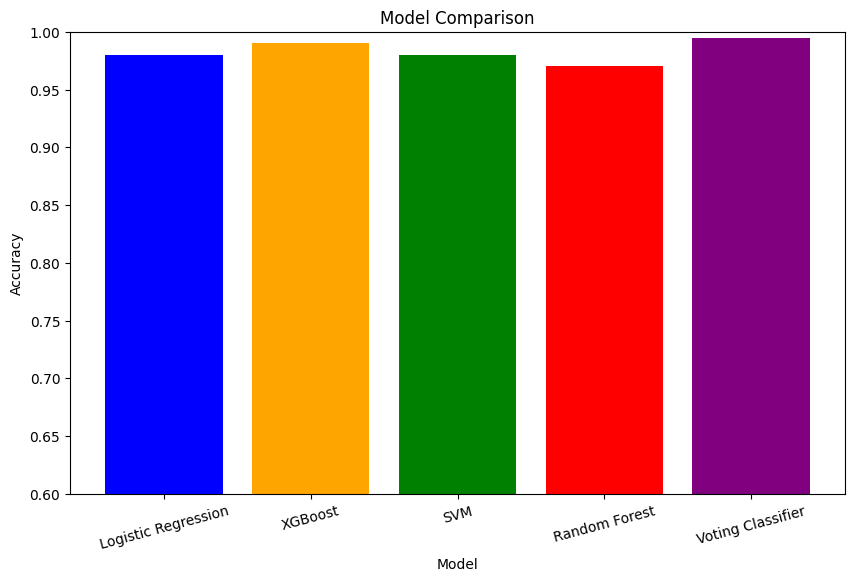

In [19]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.6, 1.0)  # Adjust as necessary
plt.xticks(rotation=15)
plt.show()

In [20]:
# Additional Evaluation using classification reports
print("Logistic Regression Report:\n", classification_report(y_test, log_reg_pred))
print("XGBoost Report:\n", classification_report(y_test, xgb_pred))
print("SVM Report:\n", classification_report(y_test, svm_pred))
print("Random Forest Report:\n", classification_report(y_test, rf_pred))
print("Voting Classifier Report:\n", classification_report(y_test, voting_pred))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       157
           1       0.91      1.00      0.96        43

    accuracy                           0.98       200
   macro avg       0.96      0.99      0.97       200
weighted avg       0.98      0.98      0.98       200

XGBoost Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       157
           1       0.98      0.98      0.98        43

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

SVM Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       157
           1       0.91      1.00      0.96        43

    accuracy                           0.98       200
   macro avg       0.96      0.99      0.97       200
weighted avg   

In [21]:
# Display Cross-Validation Scores
print("\nCross-Validation Scores:")
for model, score in cv_scores.items():
    print(f"{model}: {score:.4f}")


Cross-Validation Scores:
Logistic Regression: 0.9825
Random Forest: 0.9838
SVM: 0.9825
XGBoost: 0.9963
Voting Classifier: 0.9950


#### Save Best Model and the scaler

In [22]:
# Save model and scaler
import pickle
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)
with open('churn_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)